<a href="https://colab.research.google.com/github/siddh113/Phishing-Big-Data-Analytics/blob/main/PhishingDetection_Big_Data_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install whois

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import whois
import ssl
import socket
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
from datetime import datetime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
# Helper functions
def check_brand_mismatch(url, real_domain):
    brands = ['google', 'facebook', 'amazon', 'skype', 'microsoft', 'paypal', 'apple', 'youtube', 'linkedin', 'instagram']
    for brand in brands:
        if brand in url.lower() and brand not in real_domain.lower():
            return -1
    return 1

def check_protocol(url):
    return -1 if url.startswith('http://') else 1

def check_suspicious_subdomain(domain):
    subdomain = domain.split('.')[0]
    if any(char.isdigit() for char in subdomain) and len(subdomain) > 6:
        return -1
    else:
        return 1

def extract_additional_features(url):
    try:
        domain = urlparse(url).netloc
    except:
        domain = ""
    bm = check_brand_mismatch(url, domain)
    ps = check_protocol(url)
    ss = check_suspicious_subdomain(domain)
    return bm, ps, ss

# **Mount and Load the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PhishingDataset.csv')

Mounted at /content/drive


In [ ]:

data['Brand_Mismatch'] = np.random.choice([-1, 1], size=len(data))
data['Protocol_Safety'] = np.random.choice([-1, 1], size=len(data))
data['Suspicious_Subdomain'] = np.random.choice([-1, 1], size=len(data))

In [ ]:
print("First 5 rows of the dataset:")
print(data.head())

First 5 rows of the dataset:
   index  having_IPhaving_IP_Address  URLURL_Length  Shortining_Service  \
0      1                          -1              1                   1   
1      2                           1              1                   1   
2      3                           1              0                   1   
3      4                           1              0                   1   
4      5                           1              0                  -1   

   having_At_Symbol  double_slash_redirecting  Prefix_Suffix  \
0                 1                        -1             -1   
1                 1                         1             -1   
2                 1                         1             -1   
3                 1                         1             -1   
4                 1                         1             -1   

   having_Sub_Domain  SSLfinal_State  Domain_registeration_length  ...  \
0                 -1              -1                         

In [ ]:
print("\nDataset Info:")
print(data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   index                        11055 non-null  int64
 1   having_IPhaving_IP_Address   11055 non-null  int64
 2   URLURL_Length                11055 non-null  int64
 3   Shortining_Service           11055 non-null  int64
 4   having_At_Symbol             11055 non-null  int64
 5   double_slash_redirecting     11055 non-null  int64
 6   Prefix_Suffix                11055 non-null  int64
 7   having_Sub_Domain            11055 non-null  int64
 8   SSLfinal_State               11055 non-null  int64
 9   Domain_registeration_length  11055 non-null  int64
 10  Favicon                      11055 non-null  int64
 11  port                         11055 non-null  int64
 12  HTTPS_token                  11055 non-null  int64
 13  Request_URL                  11

In [ ]:
print("\nSummary Statistics:")
print(data.describe())


Summary Statistics:
              index  having_IPhaving_IP_Address  URLURL_Length  \
count  11055.000000                11055.000000   11055.000000   
mean    5528.000000                    0.313795      -0.633198   
std     3191.447947                    0.949534       0.766095   
min        1.000000                   -1.000000      -1.000000   
25%     2764.500000                   -1.000000      -1.000000   
50%     5528.000000                    1.000000      -1.000000   
75%     8291.500000                    1.000000      -1.000000   
max    11055.000000                    1.000000       1.000000   

       Shortining_Service  having_At_Symbol  double_slash_redirecting  \
count        11055.000000      11055.000000              11055.000000   
mean             0.738761          0.700588                  0.741474   
std              0.673998          0.713598                  0.671011   
min             -1.000000         -1.000000                 -1.000000   
25%              1.

In [ ]:
print("\nMissing Values:")
print(data.isnull().sum())



Missing Values:
index                          0
having_IPhaving_IP_Address     0
URLURL_Length                  0
Shortining_Service             0
having_At_Symbol               0
double_slash_redirecting       0
Prefix_Suffix                  0
having_Sub_Domain              0
SSLfinal_State                 0
Domain_registeration_length    0
Favicon                        0
port                           0
HTTPS_token                    0
Request_URL                    0
URL_of_Anchor                  0
Links_in_tags                  0
SFH                            0
Submitting_to_email            0
Abnormal_URL                   0
Redirect                       0
on_mouseover                   0
RightClick                     0
popUpWidnow                    0
Iframe                         0
age_of_domain                  0
DNSRecord                      0
web_traffic                    0
Page_Rank                      0
Google_Index                   0
Links_pointing_to_page    

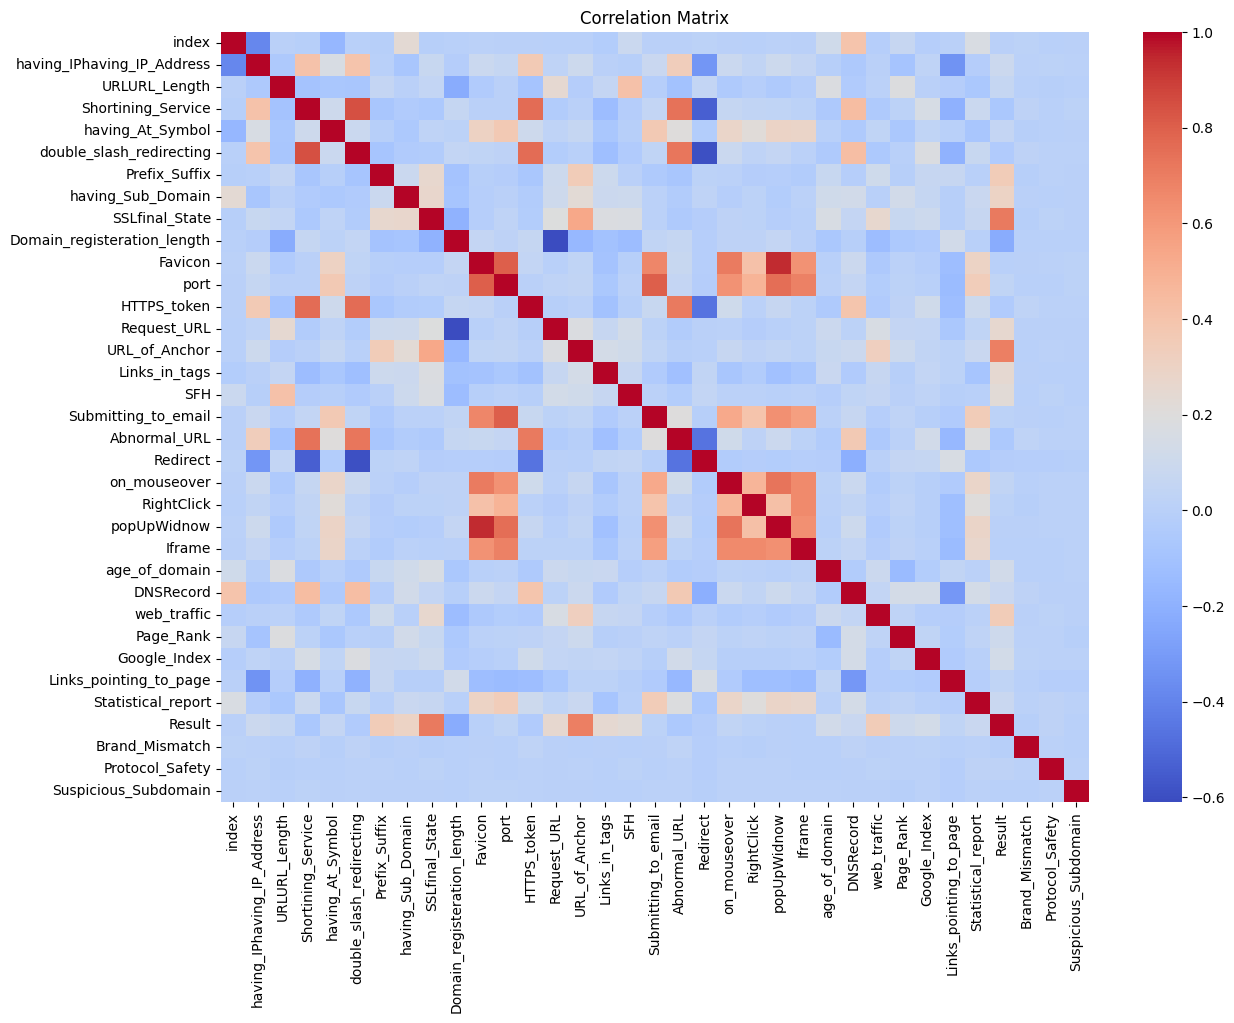

In [ ]:
plt.figure(figsize=(14, 10))
corr = data.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

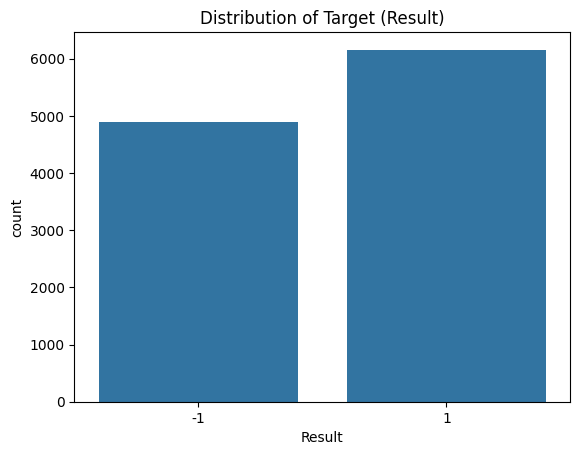

In [ ]:
sns.countplot(x='Result', data=data)
plt.title('Distribution of Target (Result)')
plt.show()

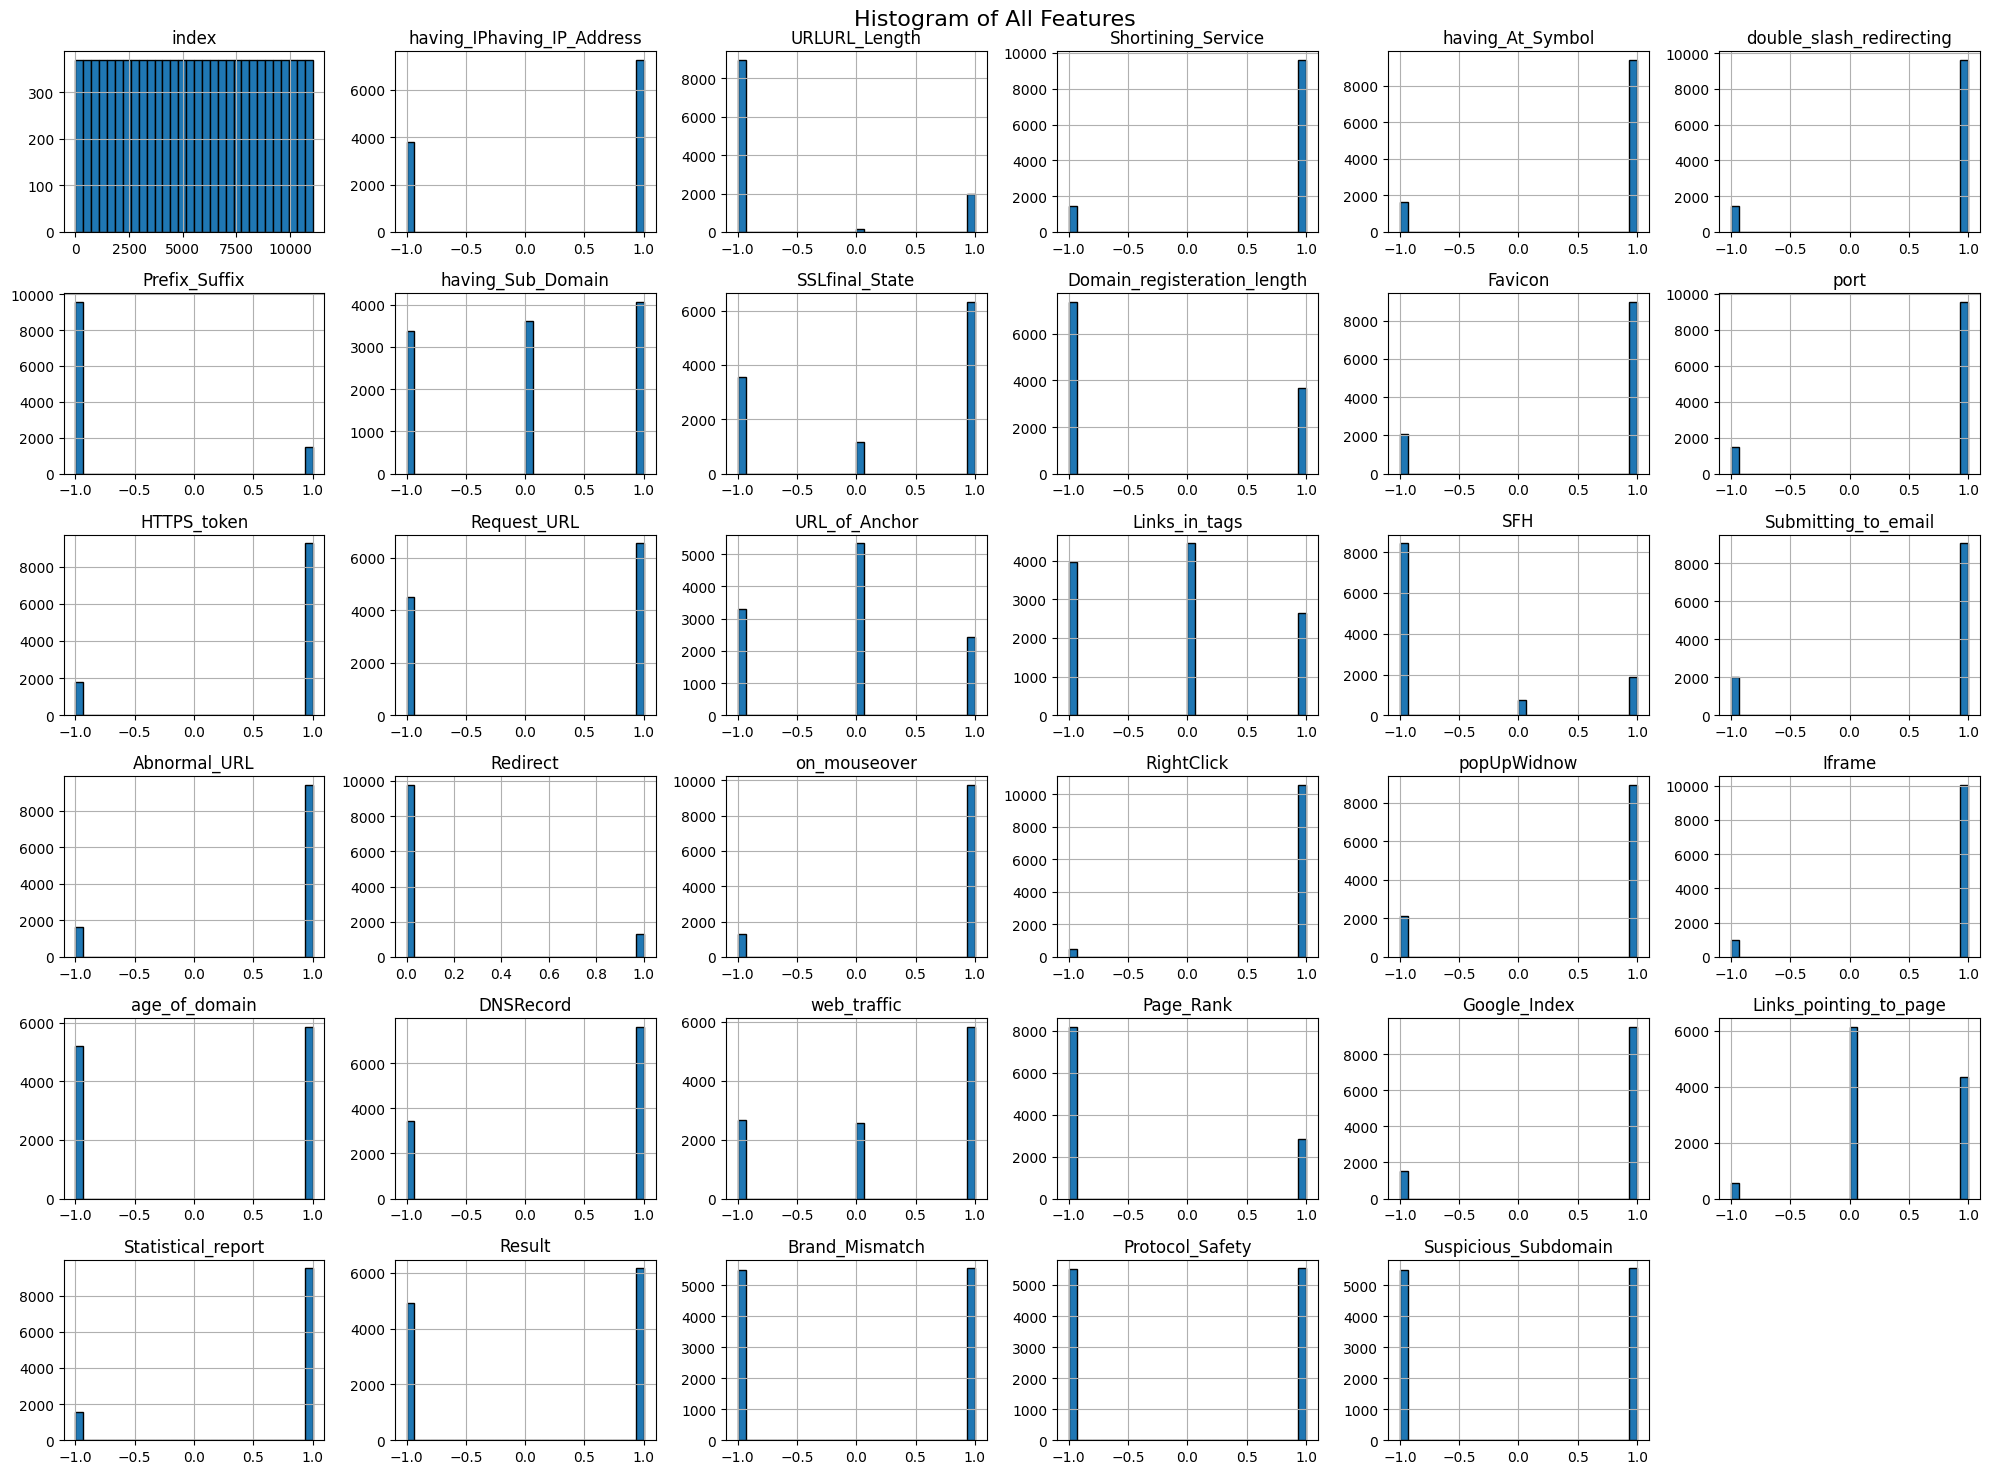

In [ ]:
data.hist(bins=30, figsize=(20, 15), edgecolor='black')
plt.suptitle("Histogram of All Features", fontsize=16)
plt.tight_layout()
plt.show()

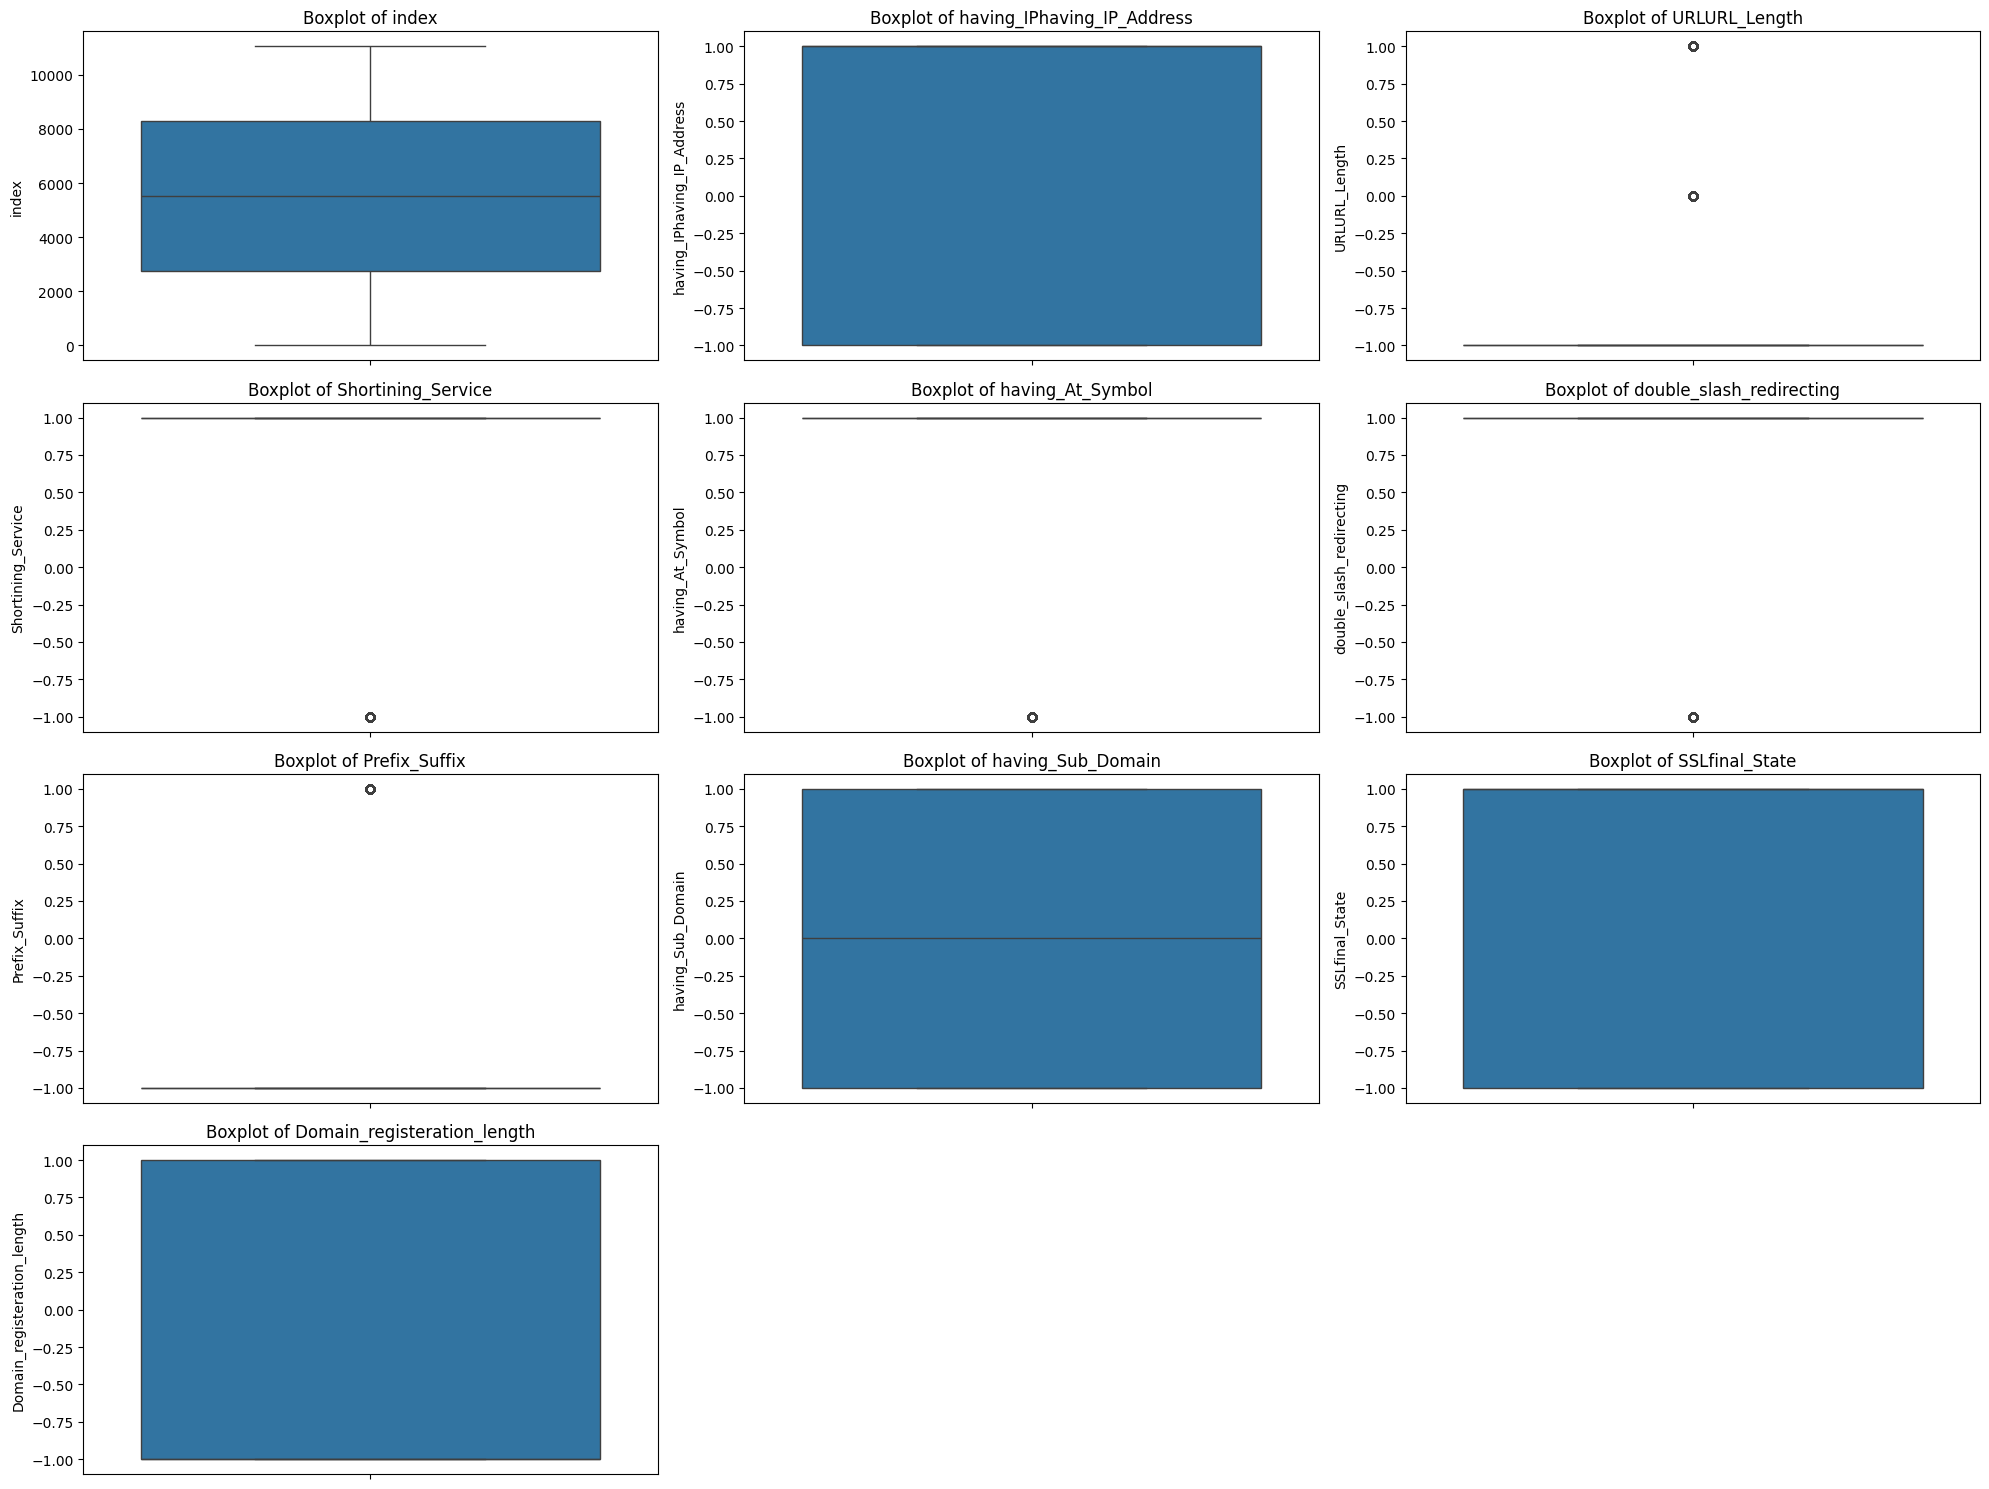

In [ ]:
plt.figure(figsize=(20, 15))
for idx, column in enumerate(data.columns[:10]):
    plt.subplot(4, 3, idx + 1)
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

# **Data Cleaning**

In [ ]:
for col in data.columns:
    if data[col].dtype == 'float64' and data[col].isnull().any():
        data[col] = data[col].fillna(data[col].mean())

# Encode categorical features
label_encoder = LabelEncoder()
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = label_encoder.fit_transform(data[column])

In [ ]:
X = data.drop('Result', axis=1)
y = data['Result'].replace(-1, 0)


print("\nUnique values in target (y):", y.unique())


Unique values in target (y): [0 1]


# **Random Forest Model**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# ------------------ Random Forest ------------------
rf_model = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy', error_score='raise')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [ ]:
print("\n✅ Best Random Forest Hyperparameters:", rf_grid.best_params_)

rf_best_model = rf_grid.best_estimator_
rf_pred = rf_best_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("🎯 Random Forest Accuracy:", rf_accuracy)
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, rf_pred))


✅ Best Random Forest Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
🎯 Random Forest Accuracy: 0.9633649932157394

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       956
           1       0.96      0.98      0.97      1255

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211



In [ ]:
# Save the trained Random Forest model
# model_path = '/content/drive/MyDrive/Colab Notebooks/phishing_rf_model2.pkl'
# joblib.dump(rf_best_model, model_path)

# print(f"✅ Model saved at {model_path}")
